# Cycle of Crime: Analyzing Police Clearance Rates

# Introduction

> Crime and bad lives are the measure of a State's failure; all crime in the end is the crime of the community.     
> \- H. G. Wells

> In 2010, Baltimore's \[homicide clearance\] rate was 56%, the national average for similarly sized cities, according to statistics compiled by The Sun. But the city's clearance rate has dropped even as violence escalated. In 2015 only 30.5% of cases cleared.
> \- [Baltimore Sun](https://www.baltimoresun.com/maryland/baltimore-city/bs-md-ci-crime-policy-20191230-zk2v2auuhbgq3f7zsh3t7rt6cm-story.html)

The devastating effect of crime on communities can be exacerbated when criminals are unlikely to be held accountable. I looked at 747,658 reports of aggravated assaults and murder from 22 different cities to see what factors were empirically linked to whether or not a police force was able to successfully clear a case.

(Data from The Trace's reporting.)

# Loading Data 

In [1]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly_express as px
import random
import seaborn as sns
import shap

import eli5
from eli5.sklearn import PermutationImportance
import xgboost as xgb
from xgboost import XGBClassifier

from pandas_profiling import ProfileReport
from pdpbox import pdp
from scipy.stats import uniform, randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


In [2]:
filename = "C:/Users/ajenk/GitHub/Crime_Data/offenses-standardized.csv"

fields = ["agency_name", "occurred_date", 
          "occurred_time", "firearm_ind", "offense_group", "domestic_violence_ind", "victim_age",
          "victim_race", "victim_ethnicity", "victim_race_condensed", "victim_sex", "clearance_group"]

crime = pd.read_csv(filename, usecols = fields)

In [3]:
def reset(filename):
   
    crime = pd.read_csv(filename)
    train, test = train_test_split(crime, test_size = .2, random_state = 42)
    
    train = create_binary_target(train)
    test = create_binary_target(test)
    
    return train, test

# Baseline Models

## Mean Classification

I begin by reading in the most usable columns from the data set. The rest of the columns are measures of the target variable, identifiers, or mostly-missing. There may be some useful information to be extracted from these, but the usable ones will be sufficient to fit baseline models.

In particular, the variables "relationship_to_offender", "arrest_date", "case_status", "arrest_ind", "clearance_status", and "clearance_date" need to be dropped to prevent direct information of whether a particular case has been cleared from "leaking" into the features. 

"Clearance status" and "clearance date" will only have values when a case has been cleared, so they need to be dropped. As the most common form of clearing a case is through arresting a suspect, arrest indicators and dates need to be dropped. Finally, "relationship to offender" will only be known when the police knows both the victim and the offender. Since" Did police identify an offender for this crime?" is part of what we're trying to predict, this needs to be dropped as well.

In [4]:
train, test = train_test_split(crime, test_size = .2, random_state = 42)

In [5]:
train, val = train_test_split(train, test_size = .2, random_state = 42)

In [6]:
train.head().T

,472468,710813,476197,115871,488426
agency_name,LOUISVILLE-MPD,TUCSON-PD,LOUISVILLE-MPD,CHICAGO-PD,LOUISVILLE-MPD
occurred_date,2005-03-12,1993-09-13,2007-03-22,2006-07-06,2013-05-13
occurred_time,23:00,16:15,04:30,16:35,00:00
firearm_ind,N,Y,N,N,N
offense_group,Agg Assault - Other Weapon,Agg Assault - Gun,Agg Assault - Other Weapon,Agg Assault - Other Weapon,Agg Assault - Other Weapon
domestic_violence_ind,Y,N,Y,N,N
victim_age,32,NaN,44,NaN,45
victim_race,W,NaN,W,NaN,B
victim_ethnicity,H,NaN,N,NaN,N
victim_race_condensed,BLACK/HISPANIC,OTHER/UNKNOWN,WHITE,OTHER/UNKNOWN,BLACK/HISPANIC


In [7]:
train["clearance_group"].value_counts()

Open & No Arrest-Unspecified           284584
Cleared-Arrest & Arrest-Unspecified    148295
Cleared/Closed-Unspecified              25331
Cleared-Ex                              20153
Null, Missing, Unclear                    137
Name: clearance_group, dtype: int64

The measure I'll predict will be whether a case was cleared. I'll turn "clearance group" into a binary variable and drop the few cases which don't have a coherent outcome in the data.

In [6]:
def create_binary_target(df):
    df = df.copy()
    df = df[df["clearance_group"] != "Null, Missing, Unclear"]
    df["cleared"] = ~(df["clearance_group"] == "Open & No Arrest-Unspecified")
    df = df.drop(["clearance_group"], axis = 1)
    return df

In [7]:
train = create_binary_target(train)
val = create_binary_target(val)
test = create_binary_target(test)

In [10]:
train["cleared"].value_counts(normalize = True)

False    0.594912
True     0.405088
Name: cleared, dtype: float64

Only 40.5% of the cases in this data set were actually cleared. Over the course of this analysis, I'll look for predictors that an incident will fall into that 40.5%. For now, I'll note that the 59.5% "uncleared" rate can be treated as a naive model, and thus is a benchmark for accuracy that our model should strive to exceed.

## Baseline Random Forest

Next I fit a quick random forest with no tuning or feature selection.

In [11]:
train.columns

Index(['agency_name', 'occurred_date', 'occurred_time', 'firearm_ind',
       'offense_group', 'domestic_violence_ind', 'victim_age', 'victim_race',
       'victim_ethnicity', 'victim_race_condensed', 'victim_sex', 'cleared'],
      dtype='object')

In [8]:
target = "cleared"
features = train.columns.drop(target).to_list()

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [13]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_jobs = -1),
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['agency_name', 'occurred_date',
                                      'occurred_time', 'firearm_ind',
                                      'offense_group', 'domestic_violence_ind',
                                      'victim_age', 'victim_race',
                                      'victim_ethnicity',
                                      'victim_race_condensed', 'victim_sex'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'agency_name',
                                          'd...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_

In [14]:
pipeline.score(X_val, y_val)

0.6541723117065583

This model manages to obtain 65% accuracy in classifying the validation set. This is better than the mean baseline, but, given the lack of tuning or feature selection/engineering, it's unlikely to be optimal. Future models can be evaluated based on whether they improve performance relative to this model.

## Baseline Logistic

I also want to fit a quick logistic model to the untuned data. This will help guide my intuition for which type of model best fits the data. Additionally, it will help clarify baseline model performance. However, the data in its current form is not well-suited to logistic regression; there are several high-cardinality variables such as raw date and time metrics. I will explore my data and do some preliminary wrangling before testing my first logistic model.

### Logistic Model Preparation: Basic Feature Cleanup

In [15]:
profile = ProfileReport(train, minimal=True).to_notebook_iframe()
profile

The pandas profiling report shows a messy data set: missing and high-cardinality data are abundant. Here I'll clean up what we have in order to fit a logistic model. But, from looking at the profile, the structure of the data set seems to suggest a model like XGBoost that is strong at dealing with missing values and higher-cardinality data might be best. 

In [16]:
def extract_time_and_date(df):
    df["occurred_date"] = pd.to_datetime(df["occurred_date"], infer_datetime_format=True)
    df["occurred_time"] = pd.to_datetime(df["occurred_time"], infer_datetime_format=True)
    
    df["hour"] = df["occurred_time"].dt.hour
    df["hour_zero"] = df["occurred_time"] == pd.to_datetime("00:00")
    df["year"] = df["occurred_date"].dt.year
    df["month"] = df["occurred_date"].dt.month
    
    df = df.drop(["occurred_date", "occurred_time"], axis = 1)
    return df

def clean_age_category(df):
    df["victim_age"] = df["victim_age"].replace({"UNDER 18": "17"})
    df["victim_age"] = df["victim_age"].astype("float")
    df.loc[df["victim_age"] > 100, "victim_age"] = np.NaN
    
    return df

def separate_black_hispanic(df):
    mask = (df["victim_race"].str.contains(
        "BLACK")) | (df["victim_race"] == "B")
    
    df.loc[mask, "victim_race_condensed"] = "BLACK"
    df["victim_race_condensed"] = df["victim_race_condensed"].replace(
        {"BLACK/HISPANIC": "HISPANIC"})
    
    return df

In [17]:
def wrangle(df):
    df = df.copy()
    df = extract_time_and_date(df)
    df = separate_black_hispanic(df)
    df = clean_age_category(df)
    
    return df

In [18]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [19]:
features = train.columns.drop(target).to_list()

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [20]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((478363, 13), (478363,), (119574, 13), (119574,), (149476, 13), (149476,))

## Fitting Logistic Model

In [21]:
pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(max_iter = 1000, n_jobs = -1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['agency_name', 'firearm_ind',
                                     'offense_group', 'domestic_violence_ind',
                                     'victim_race', 'victim_ethnicity',
                                     'victim_race_condensed', 'victim_sex'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(a...
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                     

In [22]:
pipeline.score(X_train, y_train)

0.6910923294652805

In [23]:
pipeline.score(X_val, y_val)

0.6905180055864988

A logistic model fits the training data and test data reasonably well. The 69% accuracy serves as a new benchmark. To beat these, we take a deeper dive into our data set.

# Exploring the Data

In [24]:
def generate_most_common(feature, n):
    train_plot = train.copy()
    top_obs = train_plot[feature].value_counts()[:n].index
    train_plot.loc[~train_plot[feature].isin(top_obs), feature] = "OTHER"

    return train_plot


def graph_feature(feature, n, ticksize = 16, labelsize = 25):
    train_plot = generate_most_common(feature=feature, n=n)

    fig, ax = plt.subplots(figsize=(25, 10))

    feature_title = feature.replace("_", " ").title()
    sns.countplot(x=train_plot[feature], hue=train_plot[target],
                  order=train_plot[feature].value_counts().index,
                  palette="coolwarm_r")
    ax.tick_params(axis='both', labelsize=ticksize)

    plt.title("Clearance Rates by " + feature_title, fontsize=30)
    plt.xlabel(feature_title, fontsize=labelsize)
    plt.ylabel("Count", fontsize=labelsize)
    plt.legend(("Uncleared", "Cleared"), fontsize=26)

    plt.show()

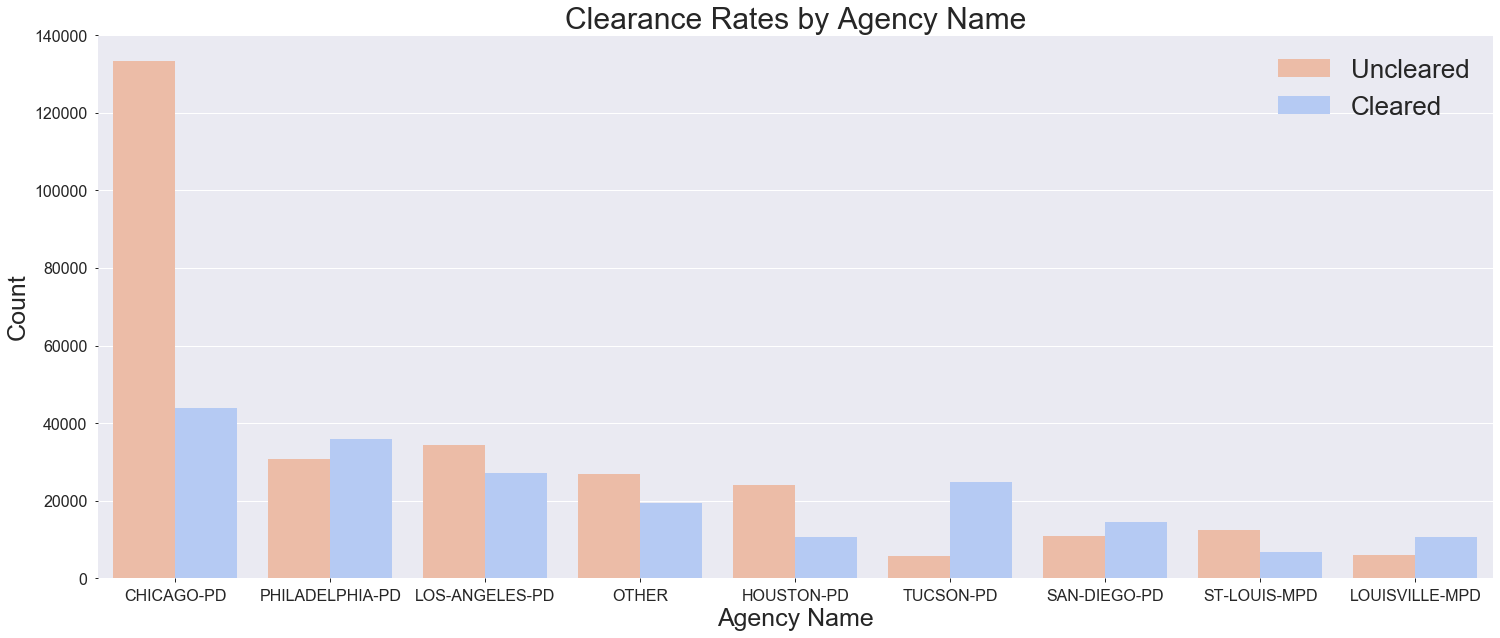

In [25]:
graph_feature("agency_name", 8)

Chicago, notorious for being a city with crime problems, has by far the most crimes in this sample and a clearance rate well below average. It's worth noting that not every agency reported identical data; however, all cities shown on this graph shared homicide and aggravated-assault data, so these numbers should be broadly comparable. It looks like the location of the crime is going to be an important variable for this model.

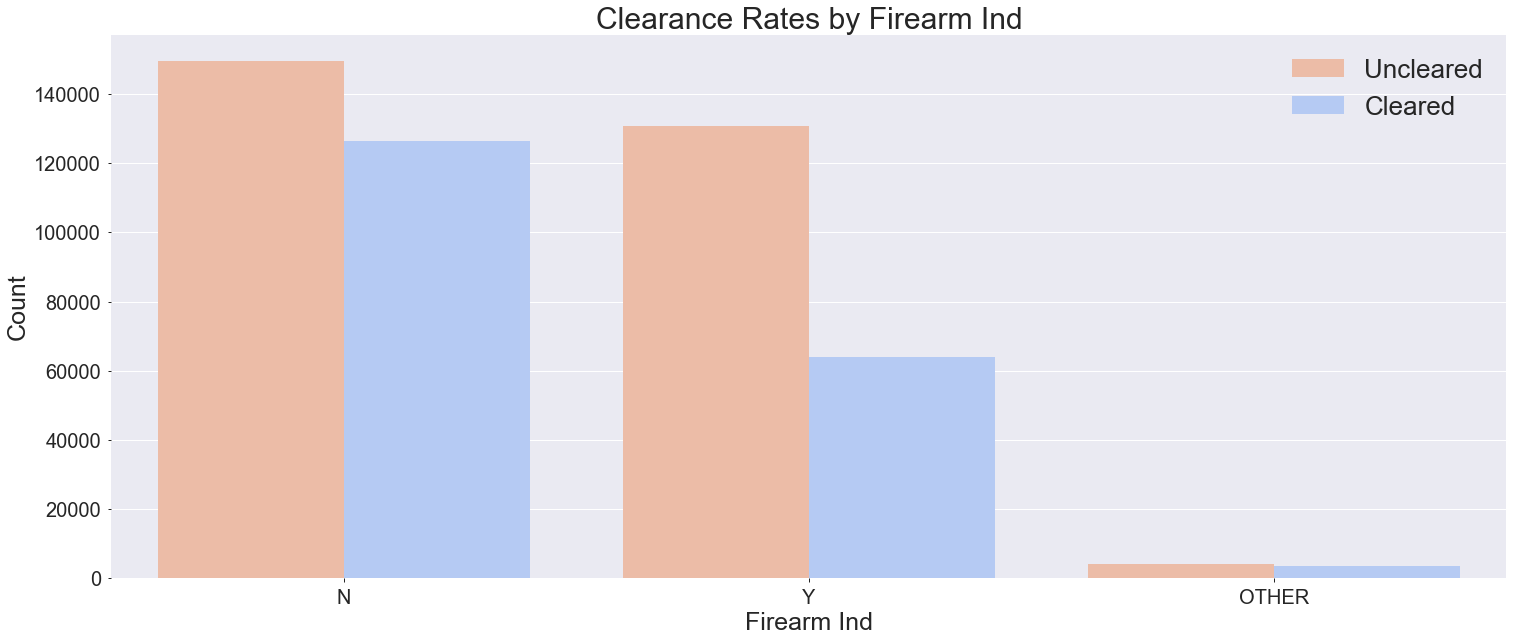

In [26]:
graph_feature("firearm_ind", 2, ticksize = 20)

Offenses using firearms were cleared at a rate dramatically lower than other crimes.

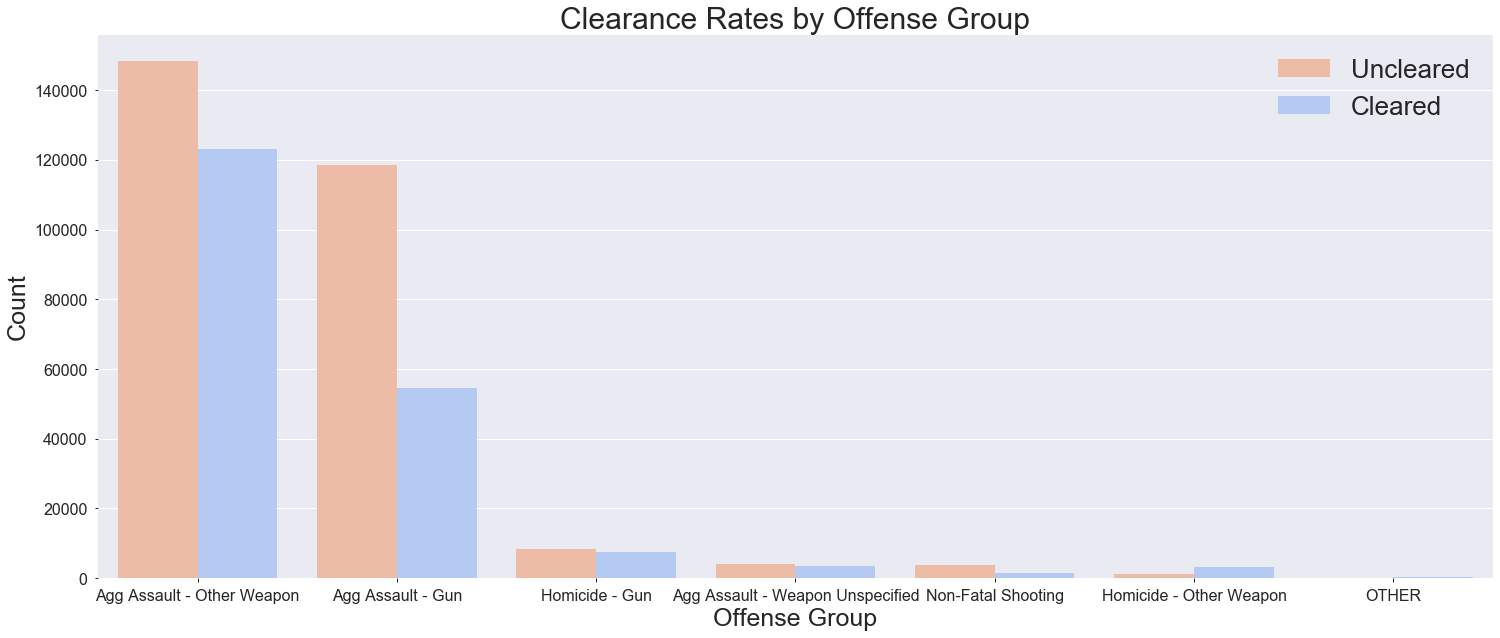

In [27]:
graph_feature("offense_group", 6)

Here we see the effect of firearms broken down by crime. Of note, a substantial majority of homicides committed with non-firearm weapons are cleared.

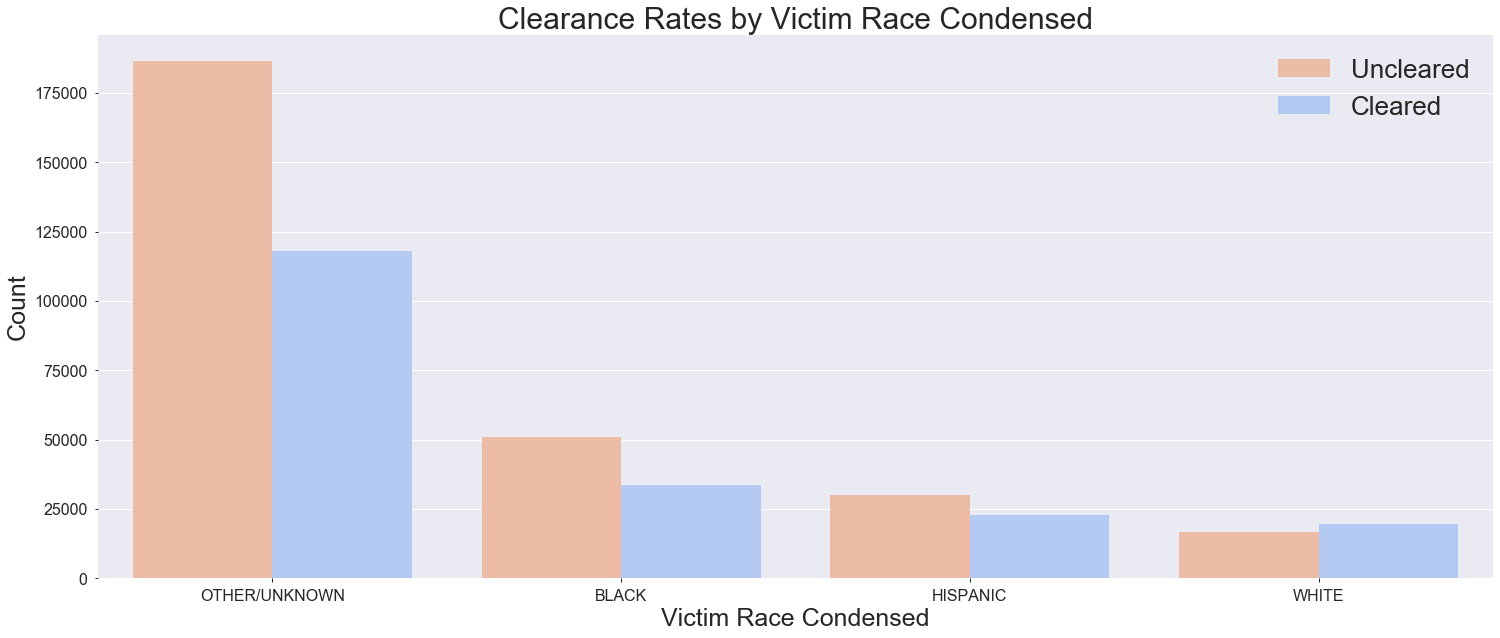

In [28]:
graph_feature("victim_race_condensed", 4)

Victim race was susceptible to reporting bias -- many departments simply did not report the race of the victim. However, among the departments that reported, there was a clear pattern: crimes where the victim was white were more likely to be cleared than crimes where the victim was Hispanic, which were more likely to be cleared than crimes where the victim was black.

In [21]:
police_data = train.groupby(["agency_name", "offense_group"])["cleared"].mean().reset_index()
police_data = police_data[(police_data["offense_group"] == "Homicide - Gun")
                          | (police_data["offense_group"] == "Homicide - Other Weapon")]

In [22]:
police_data = police_data.sort_values(by = "cleared").reset_index(drop = True)
police_data

,agency_name,offense_group,cleared
0,NEWARK-PD,Homicide - Gun,0.285953
1,BALTIMORE-PD,Homicide - Gun,0.296912
2,BOSTON-PD,Homicide - Gun,0.362018
3,CHICAGO-PD,Homicide - Gun,0.384338
4,WILMINGTON-PD,Homicide - Gun,0.390625
5,SAN-FRANCISCO-PD,Homicide - Gun,0.402878
6,PITTSBURGH-PD,Homicide - Gun,0.439698
7,NEWARK-PD,Homicide - Other Weapon,0.458716
8,ST-LOUIS-MPD,Homicide - Gun,0.461386
9,LOUISVILLE-MPD,Homicide - Gun,0.463183


From eyeballing the clearance rates by city, I suspect there's a link between city development and crime clearance rates. I've manually added the percent change from 2010 census population data to 2018 census population estimate.

In [23]:
pop_delta = pd.Series([-2.97, -2.97, 12.47, 12.47, .39, .39, 1.91, 1.91, 13.51,
             13.51, 12.29, 12.29, 19.38, 19.38, 10.72, 10.72, 10.43, 
             10.43, 5.22, 5.22, 3.81, 3.81, 2.74, 2.74,
             1.79, 1.79, 19.90, 19.90, 3.81, 3.81, -1.52, -1.52, 9.07, 
             9.07, 9.7, 9.7, -5.15, -5.15, 4.97, 4.97, -.3, -.3])

In [24]:
police_data = police_data.sort_values(by = "agency_name").reset_index(drop = True)

In [25]:
clearance_cities = pd.concat([police_data, pop_delta], axis = 1)
clearance_cities.columns = ["agency_name", "offense_group", "cleared", "population_change"]
clearance_cities = clearance_cities[clearance_cities["offense_group"] == "Homicide - Gun"]

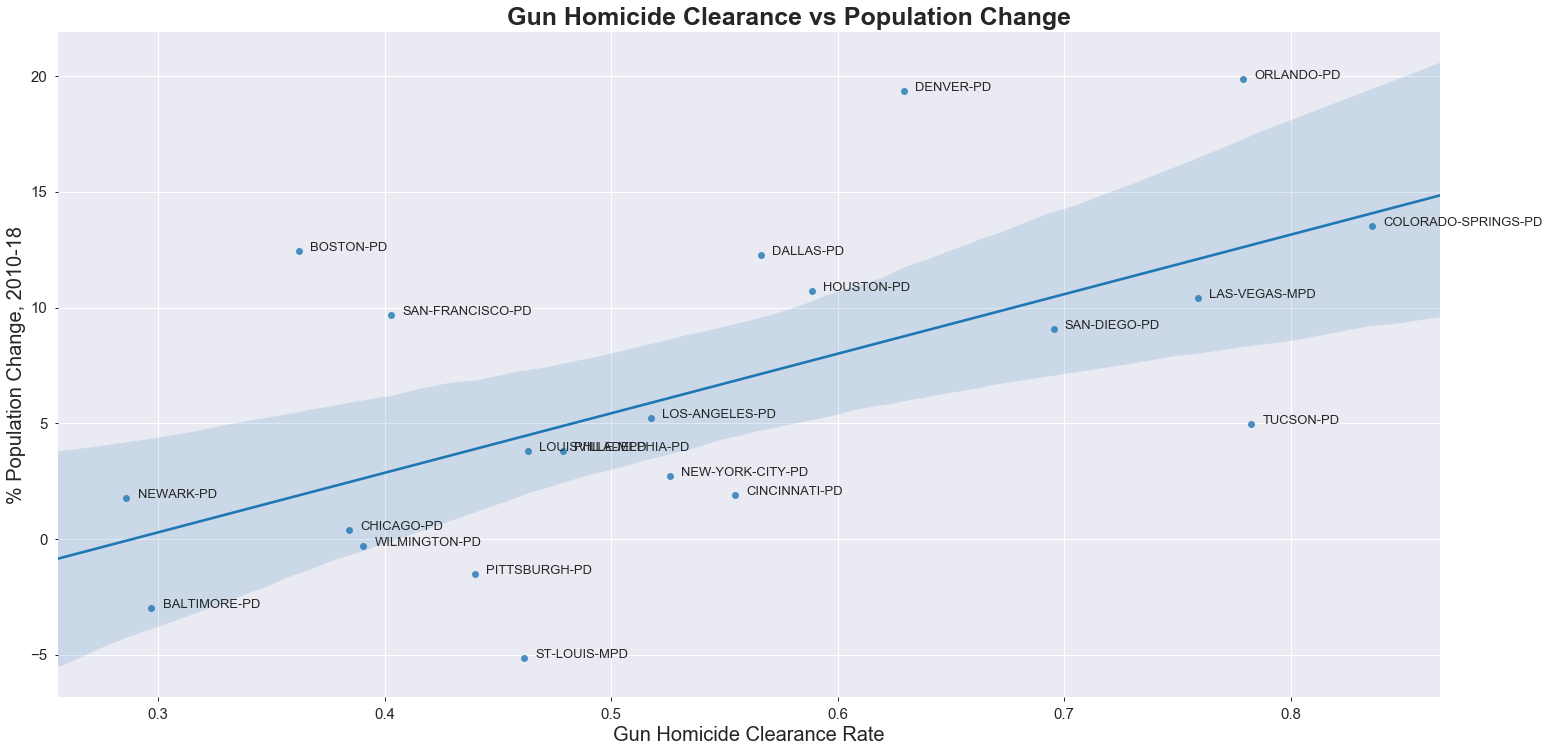

In [51]:
lm = sns.lmplot(x = "cleared", y = "population_change", 
                data = clearance_cities, size = 10, aspect = 2)
fig = lm.fig
ax2 = fig.gca()

fig.suptitle("Gun Homicide Clearance vs Population Change",
             x = .54, y = 1.02, fontsize = 25, fontweight = "bold")
plt.xlabel("Gun Homicide Clearance Rate", fontsize = 20)
plt.ylabel("% Population Change, 2010-18", fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.005, point['y'], str(point['val']), fontsize = 13)

label_point(clearance_cities["cleared"], clearance_cities["population_change"], clearance_cities["agency_name"], plt.gca())

plt.show()

Homicide clearance rates are particularly interesting, because they're the least susceptible to quirks in how various departments report or categorize particular crimes. 

There are a few strong effects that can be observed here. Firstly, every single police department clears more non-firearm homicides than firearm homicides. Secondly, it looks like there's a strong link between population change and clearance rate. Specifically, clearance rates of firearm homicide and increase/decrease in population are almost linearly correlated. 

This seems to be evidence of an underlying cycle, where crime, decreased police effectiveness, and lack of economic opportunity and development negatively reinforce one another.

In [35]:
crime_data = train.groupby(["offense_group"])["cleared"].mean().sort_values(ascending = False).reset_index()

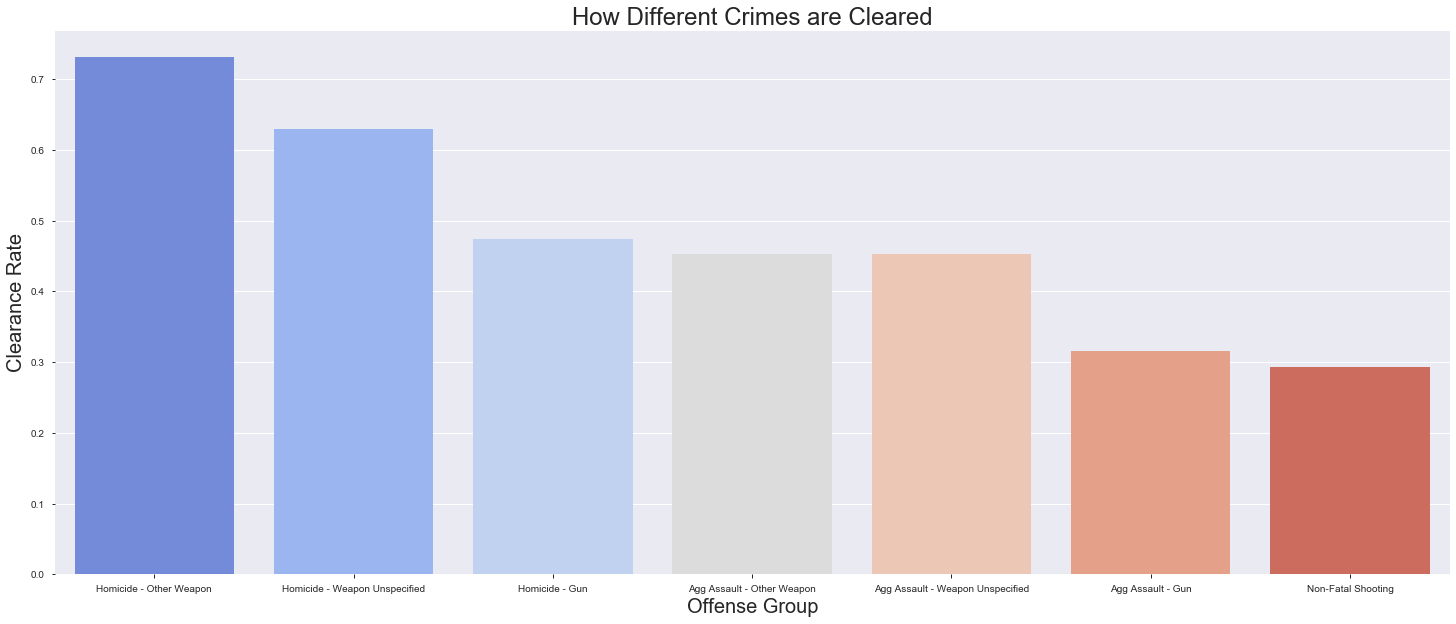

In [36]:
fig, ax = plt.subplots(figsize = (25, 10))

sns.barplot(x = "offense_group", y = "cleared", data = crime_data, palette = "coolwarm")

plt.title("How Different Crimes are Cleared", fontsize = 24)
plt.xlabel("Offense Group", fontsize = 20)
plt.ylabel("Clearance Rate", fontsize = 20)
plt.show()

# Iteration and Model Improvement

Model tuning is an experimental and iterative practice. An exhaustive reproduction of the code I used to select and engineer features, test models on those features, and tune model hyperparameters would be unwieldy. The following code represents examples of the ways in which I iterated through that process and the logic that was involved.

## Hyperparameter Tuning

I begin by exploring the performance of a tuned random forest model on these features.

In [42]:
train, test = reset(filename)
train = wrangle(train)
test = wrangle(test)

In [43]:
X_train = train[features]
y_train = train[target]
X_test = test[target]
y_test = test[target]

In [45]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state = 42)
)

param_distributions = {
    'simpleimputer__strategy' : ['mean', 'median'],
    'randomforestclassifier__n_estimators': randint(100, 1500),
    'randomforestclassifier__max_depth': [5, 15, 25, 40],
    'randomforestclassifier__min_samples_leaf': randint(3, 7)
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions = param_distributions,
    n_iter = 5,
    cv = 3,
    scoring = 'accuracy',
    verbose = 10,
    return_train_score = True,
    n_jobs = -1
    )

search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 44.0min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 52.1min remaining: 26.0min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 53.3min remaining: 13.3min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 59.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [46]:
print(search.best_params_)
print(search.best_score_)
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').T

{'randomforestclassifier__max_depth': 15, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__n_estimators': 1476, 'simpleimputer__strategy': 'median'}
0.7052933665917815


,1,4,2,0,3
mean_fit_time,1071.06,97.0522,873.992,1123.1,213.095
std_fit_time,11.4171,1.41615,96.7885,8.56603,4.57647
mean_score_time,84.8087,7.41803,96.0495,148.387,27.6867
std_score_time,4.70595,0.719976,23.6212,0.344753,3.64897
param_randomforestclassifier__max_depth,15,15,40,40,25
param_randomforestclassifier__min_samples_leaf,4,4,6,4,3
param_randomforestclassifier__n_estimators,1476,140,1117,1276,244
param_simpleimputer__strategy,median,mean,median,mean,mean
params,"{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 40, 'ran...","{'randomforestclassifier__max_depth': 40, 'ran...","{'randomforestclassifier__max_depth': 25, 'ran..."
split0_test_score,0.705554,0.705253,0.703276,0.700306,0.699392


A random forest on these variables with a depth of 15, 4 samples per leaf, and 1476 estimators, imputing mean values, produces an accuracy of 70.5%. This is another accuracy increase over our baseline models.

## Feature Importances

I use the model selected by the cross-validation process in order to examine feature and permutation importances for the model.

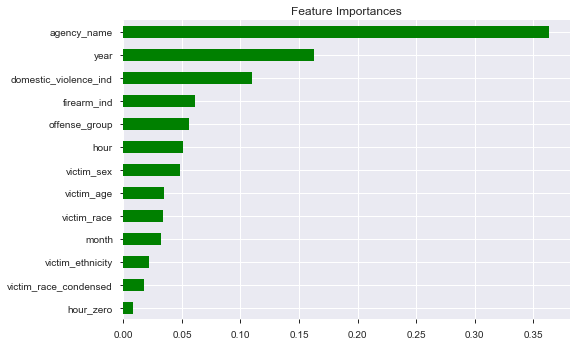

In [47]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = "mean"),
    RandomForestClassifier(max_depth = 15, n_estimators = 1476, 
                           min_samples_leaf = 4, random_state = 42, n_jobs = -1)
    )

pipeline.fit(X_train, y_train)

rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
plt.figure()
plt.title("Feature Importances")
importances.sort_values().plot.barh(color='green');


Next I examine the permutation importances for this same model.

In [49]:
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer()
)

X_train_transformed = transformers.fit_transform(X_train)

model = RandomForestClassifier(max_depth = 15, n_estimators = 1476, random_state = 42, 
                                min_samples_leaf = 4, n_jobs = -1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1476,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [51]:
print(cross_val_score(model, X_train_transformed, y_train, cv = 3))

[0.70470566 0.70553705 0.70472927]


In [53]:
X_val_transformed = transformers.transform(X_val)
permuter = PermutationImportance(
    model,
    scoring = 'accuracy',
    n_iter = 5,
    random_state = 42
)

permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter,
    top = None,
    feature_names = feature_names
)


Weight,Feature
0.0691 ± 0.0015,agency_name
0.0389 ± 0.0012,firearm_ind
0.0333 ± 0.0009,year
0.0311 ± 0.0013,domestic_violence_ind
0.0105 ± 0.0007,hour
0.0093 ± 0.0011,offense_group
0.0088 ± 0.0007,victim_sex
0.0076 ± 0.0004,victim_ethnicity
0.0067 ± 0.0002,victim_age
0.0064 ± 0.0004,month


Clearly, the agency matters quite a bit. This makes sense, as this variable represents underlying characteristics both of a city and of the police department of that city that wouldn't be captured by other variables.

Data seemed to be logged as 00:00 in the data set more than by chance; I added a flag for that hour in case there was something different about crimes committed (or logged) at that time. If there is, the model isn't picking up on it, so I drop that. The rest of the variables have at least theoretical relevance, so I've kept them in the data set to test an XGBoost model on.

In iterating my random forest model, I also tried KNN and Iterative Imputing -- neither offered a substantial model performance boost while taking substantially more computing time.

## Investigating XGBoost

As mentioned earlier, I thought XGBoost would be a good fit for this data set given the prevalence of missing data and high-cardinality data. I tested and iterated several forms of xgboost, including ones using cross-validations for a larger sample size, and distinctive hyperparameters. In the end, the following feature manipulation led to the model with the best performance. Even the data that was mostly missing values improved its performance.

Because I'm trying out new features that weren't previously loaded, I re-load and re-tune the data set. 

### Features

In [54]:
train, test = reset(filename)

In [55]:
profile = ProfileReport(train, minimal=True).to_notebook_iframe()
profile

The list of missing values is ugly. However, XGBoost can often deal well with missing data using a kitchen sink approach. 

In [56]:
irrelevant = ["row_hash", "agency_ori", "agency_incident_id"]
leakage = ["relationship_to_offender", "arrest_date", "case_status", "arrest_ind",
           "clearance_status", "clearance_date"]
missing = ["family_violence_ind", "inside_outside", "circumstance"]

I tested other features including interactions between variables, flags for major holidays (where crime is typically more common), and various derived items. Ultimately, "day of the week" was the only engineered feature I found that added substantial predictive value. The tree ensemble models are powerful and flexible enough to capture feature interactions themselves in a data set of this size.

However, including some of the mostly-missing data did improve model performance.

In [57]:
def extract_datetime_info(df):
    df["occurred_date"] = pd.to_datetime(df["occurred_date"], infer_datetime_format=True)
    df["occurred_time"] = pd.to_datetime(df["occurred_time"], infer_datetime_format=True)
    
    df["hour"] = df["occurred_time"].dt.hour
    df["year"] = df["occurred_date"].dt.year
    df["month"] = df["occurred_date"].dt.month
    df["day"] = df["occurred_date"].dt.dayofweek
    
    df = df.drop(["occurred_date", "occurred_time"], axis = 1)
    
    return df

In [58]:
def combine_categoricals(df):
    df["domestic_violence_ind"] = df["domestic_violence_ind"].replace(
        {"MISSING-JOIN": "MISSING"})
    
    df["victim_sex"] = df["victim_sex"].replace({"M": "MALE", "F": "FEMALE"})

    return df

In [59]:
def wrangle_more(df):
    df = df.copy()
    df = extract_datetime_info(df)
    df = clean_age_category(df)
    df = separate_black_hispanic(df)
    df = combine_categoricals(df)
    
    return(df)

In [60]:
train = wrangle_more(train)
test = wrangle_more(test)

In [61]:
features = train.drop([target] + irrelevant + leakage + missing, axis = 1).columns.to_list()

X_train = train[features]
y_train = train[target]

### Fitting the Model

After trying cross-validation and a wide array of hyperparameters, this model seemed to be the best. 

In [62]:
train, test = reset(filename)
train, val = train_test_split(train, test_size = .15, random_state = 42)
train = wrangle_more(train)
val = wrangle_more(val)
test = wrangle_more(test)
features = train.drop([target] + irrelevant + leakage + missing, axis = 1).columns.to_list()

In [63]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [64]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
    n_estimators = 1000,
    max_depth = 4,
    learning_rate = .2,
    n_jobs = -1,)


eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded,
          y_train,
          eval_set = eval_set,
          eval_metric = 'error',
          early_stopping_rounds = 90
          )

[0]	validation_0-error:0.312638	validation_1-error:0.313699
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90 rounds.
[1]	validation_0-error:0.305506	validation_1-error:0.306564
[2]	validation_0-error:0.303131	validation_1-error:0.304546
[3]	validation_0-error:0.302399	validation_1-error:0.3041
[4]	validation_0-error:0.300972	validation_1-error:0.302583
[5]	validation_0-error:0.301266	validation_1-error:0.302884
[6]	validation_0-error:0.298485	validation_1-error:0.299974
[7]	validation_0-error:0.297592	validation_1-error:0.298971
[8]	validation_0-error:0.298885	validation_1-error:0.30032
[9]	validation_0-error:0.297189	validation_1-error:0.298804
[10]	validation_0-error:0.295451	validation_1-error:0.297678
[11]	validation_0-error:0.295501	validation_1-error:0.297711
[12]	validation_0-error:0.295207	validation_1-error:0.297287
[13]	validation_0-error:0.295503	validation_1-error:0.29764

[132]	validation_0-error:0.283935	validation_1-error:0.288424
[133]	validation_0-error:0.283861	validation_1-error:0.288424
[134]	validation_0-error:0.283807	validation_1-error:0.288401
[135]	validation_0-error:0.283709	validation_1-error:0.288357
[136]	validation_0-error:0.283601	validation_1-error:0.288346
[137]	validation_0-error:0.283571	validation_1-error:0.288323
[138]	validation_0-error:0.283552	validation_1-error:0.288334
[139]	validation_0-error:0.283514	validation_1-error:0.288134
[140]	validation_0-error:0.283434	validation_1-error:0.288279
[141]	validation_0-error:0.283345	validation_1-error:0.288189
[142]	validation_0-error:0.283343	validation_1-error:0.288022
[143]	validation_0-error:0.283302	validation_1-error:0.288011
[144]	validation_0-error:0.283192	validation_1-error:0.288067
[145]	validation_0-error:0.283144	validation_1-error:0.288022
[146]	validation_0-error:0.283135	validation_1-error:0.288022
[147]	validation_0-error:0.283129	validation_1-error:0.288056
[148]	va

[265]	validation_0-error:0.279876	validation_1-error:0.28606
[266]	validation_0-error:0.27988	validation_1-error:0.28606
[267]	validation_0-error:0.279861	validation_1-error:0.286015
[268]	validation_0-error:0.279855	validation_1-error:0.286015
[269]	validation_0-error:0.279843	validation_1-error:0.286015
[270]	validation_0-error:0.279829	validation_1-error:0.285982
[271]	validation_0-error:0.279827	validation_1-error:0.285971
[272]	validation_0-error:0.279809	validation_1-error:0.286015
[273]	validation_0-error:0.279756	validation_1-error:0.28596
[274]	validation_0-error:0.279683	validation_1-error:0.285904
[275]	validation_0-error:0.279644	validation_1-error:0.285982
[276]	validation_0-error:0.27966	validation_1-error:0.285971
[277]	validation_0-error:0.279601	validation_1-error:0.285982
[278]	validation_0-error:0.279605	validation_1-error:0.285904
[279]	validation_0-error:0.279579	validation_1-error:0.285971
[280]	validation_0-error:0.279565	validation_1-error:0.286049
[281]	validat

[398]	validation_0-error:0.277657	validation_1-error:0.285324
[399]	validation_0-error:0.277667	validation_1-error:0.285413
[400]	validation_0-error:0.277649	validation_1-error:0.28538
[401]	validation_0-error:0.277651	validation_1-error:0.285201
[402]	validation_0-error:0.277614	validation_1-error:0.285213
[403]	validation_0-error:0.2776	validation_1-error:0.28519
[404]	validation_0-error:0.27759	validation_1-error:0.285157
[405]	validation_0-error:0.27756	validation_1-error:0.285279
[406]	validation_0-error:0.277551	validation_1-error:0.285268
[407]	validation_0-error:0.277551	validation_1-error:0.285313
[408]	validation_0-error:0.277531	validation_1-error:0.285313
[409]	validation_0-error:0.277517	validation_1-error:0.285235
[410]	validation_0-error:0.277523	validation_1-error:0.285246
[411]	validation_0-error:0.277519	validation_1-error:0.285246
[412]	validation_0-error:0.277525	validation_1-error:0.285268
[413]	validation_0-error:0.277521	validation_1-error:0.285279
[414]	validati

[531]	validation_0-error:0.276177	validation_1-error:0.285224
[532]	validation_0-error:0.276167	validation_1-error:0.285246
[533]	validation_0-error:0.276152	validation_1-error:0.285257
[534]	validation_0-error:0.276148	validation_1-error:0.285268
[535]	validation_0-error:0.276134	validation_1-error:0.285257
[536]	validation_0-error:0.276124	validation_1-error:0.285246
[537]	validation_0-error:0.276124	validation_1-error:0.285224
[538]	validation_0-error:0.276095	validation_1-error:0.285246
[539]	validation_0-error:0.276083	validation_1-error:0.285201
[540]	validation_0-error:0.276087	validation_1-error:0.285213
[541]	validation_0-error:0.276087	validation_1-error:0.28519
[542]	validation_0-error:0.276101	validation_1-error:0.285201
[543]	validation_0-error:0.276087	validation_1-error:0.285157
[544]	validation_0-error:0.276085	validation_1-error:0.285157
[545]	validation_0-error:0.276081	validation_1-error:0.285157
[546]	validation_0-error:0.276077	validation_1-error:0.285157
[547]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Our best XGBoost model with chosen hyperparameters and a more inclusive approach to the data gives a validation accuracy of .715, an improvement over the previous models.

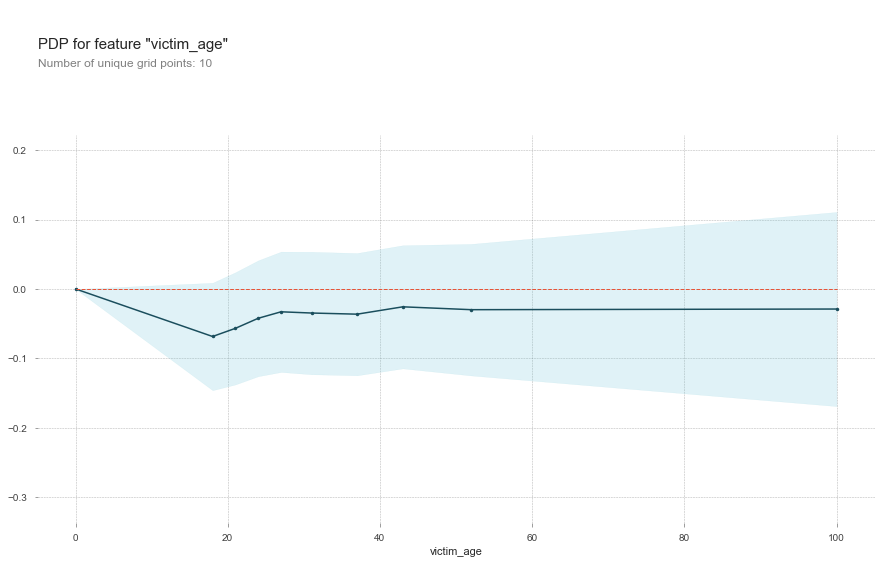

In [69]:
feature = "victim_age"
pdp_dist = pdp.pdp_isolate(model = model, 
                                 dataset = X_train_encoded.dropna(), 
                                 model_features = features, 
                                 feature = feature)
pdp.pdp_plot(pdp_dist, feature)
plt.show()

Children who are victims of crime have the best chance of having their perpetrators caught; the model suggests that, relative to young children, victims who are between 18 and 25 have, all else constant, around 8 percentage points less of a chance to have their case cleared.

In [66]:
X_test_encoded = encoder.transform(X_test)
model.score(X_test_encoded, y_test)

0.7172255077738232

Finally, we test this model on our test data. This model scores 71.7%, meaning it accurately predicts whether cases will be cleared 71.7% of the time in the test data. As this is comparable to our training and validation scores, we can be confident that this model is not overfitting on the data, and, if the relationships in this data set hold, will generalize to future data effectively. 

# Conclusion

This data set illuminated the cyclical, interlinked nature of crime problems in communities. High crime leads to overworked police departments; gun availability leads to crimes that are tougher to solve; both lead to low clearance rates, which lead to criminal impunity and distrust between citizens and police, which lead back to the initial problems. Over time, this cycle results in people and businesses leaving communities, which depresses economic performance, which leads to more crime. The fact that each of these things (crime rate, firearm presence, population delta, race of victim) was independently correlated with clearance rate reinforced this.